In [1]:
import warnings
from pathlib import Path
import duckdb
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

CWD = Path().resolve()

DB_FILE = None
for p in [CWD] + list(CWD.parents):
    cand = p / "db" / "nflpa.duckdb"
    if cand.exists():
        DB_FILE = cand
        break
if DB_FILE is None:
    for p in [CWD] + list(CWD.parents):
        cand = p / "nflpa.duckdb"
        if cand.exists():
            DB_FILE = cand
            break
if DB_FILE is None:
    raise RuntimeError("Could not find nflpa.duckdb")

con = duckdb.connect(str(DB_FILE), read_only=False)

print("connected db", str(DB_FILE))
print(con.execute("SHOW TABLES").df().head(25))

connected db /Users/ramko/Desktop/2025-26-NFLPA-Data-Analytics-Case-Competition/db/nflpa.duckdb
                                         name
0                                    injuries
1                   injuries_players_distinct
2                  injuries_team_week_players
3                          injury_counts_next
4                     injury_counts_next_game
5           injury_counts_next_game_with_lags
6                     injury_counts_with_lags
7               injury_outcomes_next_game_tmp
8                         injury_outcomes_tmp
9                    injury_players_next_game
10                           injury_players_w
11                    injury_players_w_plus_1
12            new_injured_players_mapped_side
13     new_injured_players_next_game_eligible
14  new_injured_players_next_game_mapped_side
15          new_injured_players_next_game_raw
16      new_injured_players_w_plus_1_eligible
17           new_injured_players_w_plus_1_raw
18                     new_inj

In [2]:
def _first_existing(df_cols, candidates):
    s = set([str(c) for c in df_cols])
    for c in candidates:
        if c in s:
            return c
    return None

pbp_cols = con.execute("DESCRIBE pbp").df()["column_name"].astype(str).tolist()

SEASON_COL = _first_existing(pbp_cols, ["season", "Season"])
WEEK_COL = _first_existing(pbp_cols, ["week", "Week"])
GAME_COL = _first_existing(pbp_cols, ["game_id", "gsis_id", "GameID"])
POSTEAM_COL = _first_existing(pbp_cols, ["posteam", "pos_team", "possession_team"])
DEFTEAM_COL = _first_existing(pbp_cols, ["defteam", "def_team", "defensive_team"])
PLAYTYPE_COL = _first_existing(pbp_cols, ["play_type", "PlayType"])

if SEASON_COL is None or WEEK_COL is None or GAME_COL is None or POSTEAM_COL is None or DEFTEAM_COL is None or PLAYTYPE_COL is None:
    raise RuntimeError("pbp missing required columns, inspect DESCRIBE pbp output")

role_cols = {
    "kicker": _first_existing(pbp_cols, ["kicker_player_id", "kicker_id"]),
    "punter": _first_existing(pbp_cols, ["punter_player_id", "punter_id"]),
    "returner": _first_existing(pbp_cols, ["returner_player_id", "returner_id"]),
    "kick_returner": _first_existing(pbp_cols, ["kick_returner_player_id", "kick_returner_id"]),
    "punt_returner": _first_existing(pbp_cols, ["punt_returner_player_id", "punt_returner_id"]),
    "long_snapper": _first_existing(pbp_cols, ["long_snapper_player_id", "long_snapper_id", "ls_player_id"]),
}

print("pbp cols used")
print("season", SEASON_COL)
print("week", WEEK_COL)
print("game", GAME_COL)
print("posteam", POSTEAM_COL)
print("defteam", DEFTEAM_COL)
print("play_type", PLAYTYPE_COL)
print("roles", role_cols)

pbp cols used
season season
week week
game game_id
posteam posteam
defteam defteam
play_type play_type
roles {'kicker': 'kicker_player_id', 'punter': 'punter_player_id', 'returner': None, 'kick_returner': None, 'punt_returner': 'punt_returner_player_id', 'long_snapper': None}


In [3]:
st_play_types = ["kickoff", "punt", "field_goal", "extra_point"]

base_cols = [SEASON_COL, WEEK_COL, GAME_COL, POSTEAM_COL, DEFTEAM_COL, PLAYTYPE_COL]
use_role_cols = [c for c in role_cols.values() if c is not None]
use_cols = base_cols + use_role_cols

pbp_st = con.execute(f"""
SELECT {", ".join(use_cols)}
FROM pbp
WHERE lower({PLAYTYPE_COL}) IN ({", ".join(["'" + x + "'" for x in st_play_types])})
""").df()

for c in [POSTEAM_COL, DEFTEAM_COL]:
    pbp_st[c] = pbp_st[c].astype(str)

print("pbp st rows", len(pbp_st))
pbp_st.head()

pbp st rows 97373


,season,week,game_id,posteam,defteam,play_type,kicker_player_id,punter_player_id,punt_returner_player_id
0,2012,1,2012_01_ATL_KC,ATL,KC,kickoff,00-0026968,None,None
1,2012,1,2012_01_ATL_KC,ATL,KC,extra_point,00-0020578,None,None
2,2012,1,2012_01_ATL_KC,KC,ATL,kickoff,00-0028130,None,None
3,2012,1,2012_01_ATL_KC,KC,ATL,field_goal,00-0026968,None,None
4,2012,1,2012_01_ATL_KC,ATL,KC,kickoff,00-0026968,None,None


In [4]:
rows = []

def _add_role(role, player_col, team_series):
    if player_col is None:
        return

    tmp = pbp_st[[SEASON_COL, WEEK_COL, GAME_COL, PLAYTYPE_COL, player_col]].copy()
    tmp = tmp.rename(columns={player_col: "player_id"})

    tmp["player_id"] = tmp["player_id"].astype(str)
    tmp = tmp[
        tmp["player_id"].notna()
        & (tmp["player_id"] != "None")
        & (tmp["player_id"] != "nan")
        & (tmp["player_id"] != "")
    ]

    tmp["role"] = role
    tmp["team"] = team_series.loc[tmp.index].astype(str)

    rows.append(tmp[[SEASON_COL, WEEK_COL, GAME_COL, "team", "player_id", "role", PLAYTYPE_COL]])

kicking_team = pbp_st[POSTEAM_COL]
return_team = pbp_st[DEFTEAM_COL]

_add_role("kicker", role_cols["kicker"], kicking_team)
_add_role("punter", role_cols["punter"], kicking_team)
_add_role("long_snapper", role_cols["long_snapper"], kicking_team)

_add_role("returner", role_cols["returner"], return_team)
_add_role("kick_returner", role_cols["kick_returner"], return_team)
_add_role("punt_returner", role_cols["punt_returner"], return_team)

st_involvements = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
st_involvements = st_involvements.rename(
    columns={SEASON_COL: "season", WEEK_COL: "week", GAME_COL: "game_id", PLAYTYPE_COL: "play_type"}
)
st_involvements["team"] = st_involvements["team"].astype(str)

print("st involvements rows", len(st_involvements))
st_involvements.head(20)

st involvements rows 118768


,season,week,game_id,team,player_id,role,play_type
0,2012,1,2012_01_ATL_KC,ATL,00-0026968,kicker,kickoff
1,2012,1,2012_01_ATL_KC,ATL,00-0020578,kicker,extra_point
2,2012,1,2012_01_ATL_KC,KC,00-0028130,kicker,kickoff
3,2012,1,2012_01_ATL_KC,KC,00-0026968,kicker,field_goal
4,2012,1,2012_01_ATL_KC,ATL,00-0026968,kicker,kickoff
5,2012,1,2012_01_ATL_KC,ATL,00-0020578,kicker,field_goal
6,2012,1,2012_01_ATL_KC,KC,00-0028130,kicker,kickoff
7,2012,1,2012_01_ATL_KC,KC,00-0026968,kicker,extra_point
8,2012,1,2012_01_ATL_KC,ATL,00-0026968,kicker,kickoff
9,2012,1,2012_01_ATL_KC,ATL,00-0020578,kicker,extra_point


In [5]:
rost_cols = con.execute("DESCRIBE rosters_weekly").df()["column_name"].astype(str).tolist()

R_SEASON = _first_existing(rost_cols, ["season", "Season"])
R_WEEK = _first_existing(rost_cols, ["week", "Week"])
R_TEAM = _first_existing(rost_cols, ["team", "team_key", "Team"])
R_PID = _first_existing(rost_cols, ["player_id", "gsis_id", "nfl_id", "player_gsis_id"])
R_POS = _first_existing(rost_cols, ["position", "pos", "Position"])

if R_SEASON is None or R_WEEK is None or R_TEAM is None or R_PID is None or R_POS is None:
    raise RuntimeError("rosters_weekly missing required columns, inspect DESCRIBE rosters_weekly output")

rosters = con.execute(f"""
SELECT
  {R_SEASON} AS season,
  {R_WEEK} AS week,
  {R_TEAM} AS team,
  {R_PID} AS player_id,
  {R_POS} AS pos
FROM rosters_weekly
""").df()

rosters["season"] = rosters["season"].astype(int)
rosters["week"] = rosters["week"].astype(int)
rosters["team"] = rosters["team"].astype(str)
rosters["player_id"] = rosters["player_id"].astype(str)
rosters["pos"] = rosters["pos"].astype(str)

rosters = rosters.drop_duplicates(subset=["season", "week", "team", "player_id"], keep="last")

print("rosters rows", len(rosters))
rosters.head()

rosters rows 540194


,season,week,team,player_id,pos
0,2012,12,SF,00-0000108,K
1,2012,16,SF,00-0000108,K
2,2012,8,SF,00-0000108,K
3,2012,1,SF,00-0000108,K
4,2012,11,SF,00-0000108,K


In [6]:
OFF_POS = set(["QB","RB","FB","WR","TE","OL","C","G","LG","RG","T","LT","RT","OT"])
DEF_POS = set(["DL","DT","NT","DE","EDGE","LB","ILB","OLB","MLB","DB","CB","S","SS","FS","SAF"])
SPEC_POS = set(["K","P","LS","PK","KP"])

def _side_from_pos(pos):
    p = str(pos).upper().strip()
    if p in OFF_POS:
        return "OFF"
    if p in DEF_POS:
        return "DEF"
    if p in SPEC_POS:
        return "SPEC"
    return "OTHER"

st_involvements["season"] = st_involvements["season"].astype(int)
st_involvements["week"] = st_involvements["week"].astype(int)
st_involvements["player_id"] = st_involvements["player_id"].astype(str)

st_tagged = st_involvements.merge(
    rosters,
    on=["season", "week", "team", "player_id"],
    how="left",
)

st_tagged["side"] = st_tagged["pos"].apply(_side_from_pos)

missing_pos = st_tagged["pos"].isna().mean()
print("share missing roster pos on st involvements", float(missing_pos))
st_tagged.head(20)

share missing roster pos on st involvements 0.36305233732992054


,season,week,game_id,team,player_id,role,play_type,pos,side
0,2012,1,2012_01_ATL_KC,ATL,00-0026968,kicker,kickoff,NaN,OTHER
1,2012,1,2012_01_ATL_KC,ATL,00-0020578,kicker,extra_point,K,SPEC
2,2012,1,2012_01_ATL_KC,KC,00-0028130,kicker,kickoff,NaN,OTHER
3,2012,1,2012_01_ATL_KC,KC,00-0026968,kicker,field_goal,K,SPEC
4,2012,1,2012_01_ATL_KC,ATL,00-0026968,kicker,kickoff,NaN,OTHER
5,2012,1,2012_01_ATL_KC,ATL,00-0020578,kicker,field_goal,K,SPEC
6,2012,1,2012_01_ATL_KC,KC,00-0028130,kicker,kickoff,NaN,OTHER
7,2012,1,2012_01_ATL_KC,KC,00-0026968,kicker,extra_point,K,SPEC
8,2012,1,2012_01_ATL_KC,ATL,00-0026968,kicker,kickoff,NaN,OTHER
9,2012,1,2012_01_ATL_KC,ATL,00-0020578,kicker,extra_point,K,SPEC


In [7]:
by_side = (
    st_tagged
    .groupby(["side"], as_index=False)
    .agg(
        involvements=("player_id", "size"),
        unique_players=("player_id", "nunique"),
    )
)
by_side["share_involvements"] = by_side["involvements"] / by_side["involvements"].sum()

by_side_non_spec = by_side[by_side["side"].isin(["OFF", "DEF"])].copy()
by_side_non_spec["share_involvements_off_vs_def"] = by_side_non_spec["involvements"] / by_side_non_spec["involvements"].sum()

print(by_side.sort_values("involvements", ascending=False))
print()
print("off vs def only")
print(by_side_non_spec.sort_values("involvements", ascending=False))

    side  involvements  unique_players  share_involvements
3   SPEC         56075             216            0.472139
2  OTHER         43119             281            0.363052
1    OFF         17041             364            0.143481
0    DEF          2533             158            0.021327

off vs def only
  side  involvements  unique_players  share_involvements  \
1  OFF         17041             364            0.143481   
0  DEF          2533             158            0.021327   

   share_involvements_off_vs_def  
1                       0.870594  
0                       0.129406  


In [8]:
by_season_side = (
    st_tagged
    .groupby(["season", "side"], as_index=False)
    .agg(involvements=("player_id", "size"), unique_players=("player_id", "nunique"))
)

tmp = by_season_side[by_season_side["side"].isin(["OFF","DEF"])].copy()
den = tmp.groupby("season", as_index=False)["involvements"].sum().rename(columns={"involvements":"inv_total_off_def"})
tmp = tmp.merge(den, on="season", how="left")
tmp["share_off_def"] = tmp["involvements"] / tmp["inv_total_off_def"]

pivot = tmp.pivot_table(index="season", columns="side", values="share_off_def", aggfunc="mean").reset_index()
pivot = pivot.rename(columns={"OFF":"share_off", "DEF":"share_def"})

print(pivot)

side  season  share_def  share_off
0       2012   0.223859   0.776141
1       2013   0.158650   0.841350
2       2014   0.113139   0.886861
3       2015   0.119064   0.880936
4       2016   0.122688   0.877312
5       2017   0.162021   0.837979
6       2018   0.206784   0.793216
7       2019   0.112979   0.887021
8       2020   0.066906   0.933094
9       2021   0.110667   0.889333
10      2022   0.099326   0.900674
11      2023   0.089934   0.910066
12      2024   0.101488   0.898512


In [9]:
from pathlib import Path

out_dir = Path("../outputs")
out_dir.mkdir(parents=True, exist_ok=True)

con.register("st_tagged_tmp", st_tagged)
con.execute("CREATE OR REPLACE TABLE step22_st_play_involvements_tagged AS SELECT * FROM st_tagged_tmp")
con.unregister("st_tagged_tmp")

con.register("by_side_tmp", by_side)
con.execute("CREATE OR REPLACE TABLE step22_st_involvement_side_summary AS SELECT * FROM by_side_tmp")
con.unregister("by_side_tmp")

con.register("pivot_tmp", pivot)
con.execute("CREATE OR REPLACE TABLE step22_st_involvement_share_by_season AS SELECT * FROM pivot_tmp")
con.unregister("pivot_tmp")

st_tagged.to_csv(out_dir / "step22_st_play_involvements_tagged.csv", index=False)
by_side.to_csv(out_dir / "step22_st_involvement_side_summary.csv", index=False)
pivot.to_csv(out_dir / "step22_st_involvement_share_by_season.csv", index=False)

print("wrote step22 st involvement tables and csv outputs")

wrote step22 st involvement tables and csv outputs


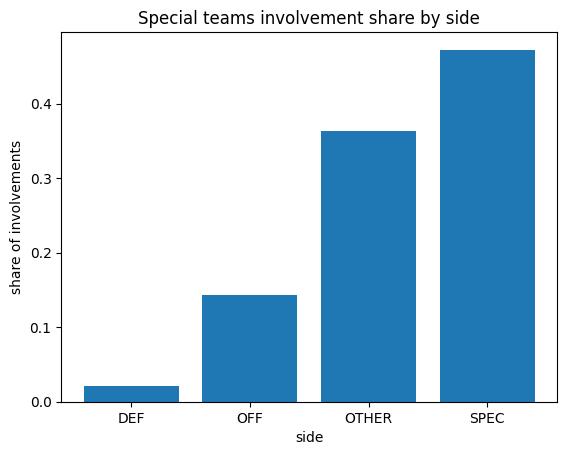

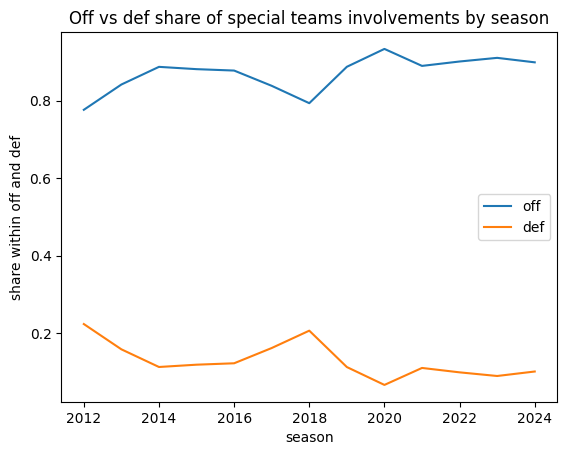

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(by_side["side"].astype(str), by_side["share_involvements"].astype(float))
plt.title("Special teams involvement share by side")
plt.xlabel("side")
plt.ylabel("share of involvements")
plt.show()

plt.figure()
plt.plot(pivot["season"].astype(int), pivot.get("share_off", np.nan), label="off")
plt.plot(pivot["season"].astype(int), pivot.get("share_def", np.nan), label="def")
plt.title("Off vs def share of special teams involvements by season")
plt.xlabel("season")
plt.ylabel("share within off and def")
plt.legend()
plt.show()